In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
df.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [2]:
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

# Feature Engineering

Handle missing values:

All columns:
- Drop any with 5% or more missing values for now.

Text columns:
- Drop any with 1 or more missing values for now.

Numerical columns:
- For columns with missing values, fill in with the most common value in that column

# Update transform_features function

In [3]:
def transform_features(df):
    column_to_drop = []
    
    # Remove columns with more than 15% missing values
    for col in df.columns:
        if df[col].isnull().sum() > len(df) * .05:
            column_to_drop.append(col)
    # Fill columns with less than 15% missing values
    for col in df.columns:
           if (df[col].isnull().sum() < len(df) * .05) and (df[col].isnull().sum() > 0):
                col_popular = df[col].value_counts().idxmax()
                df[col] = df[col].fillna(col_popular)

    
    # Drop text columns with more than 1 missing value
    text_col =  df.select_dtypes(include=['object']).columns
    for col in text_col:
        if df[col].isnull().sum() >= 1:
            column_to_drop.append(col)
    
    # Add columns relating to model/buil/sold year
    home_age = df['Yr Sold'] - df['Year Built']
    df['home_age'] = home_age
    until_remod = df['Year Remod/Add'] - df['Year Built']
    df['years_until_remod'] = until_remod
    after_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['years_after_remod'] = after_remod
    column_to_drop.extend(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", 'Year Built', 'Year Remod/Add'])
    
    df = df.drop(column_to_drop, axis=1)
    
    return df

In [4]:
def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

In [5]:
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    rg = linear_model.LinearRegression()
    
    numeric_train = train.select_dtypes(['int', 'float'])
    numeric_test = test.select_dtypes(['int', 'float'])
    
    features = numeric_train.columns.drop('SalePrice')
    rg.fit(numeric_train[features], numeric_train['SalePrice'])
    predict = rg.predict(numeric_test[features])
    rmse = mean_squared_error(numeric_test['SalePrice'], predict) ** (1/2)
    return rmse    

In [6]:
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.251612639091

# Select numerical features

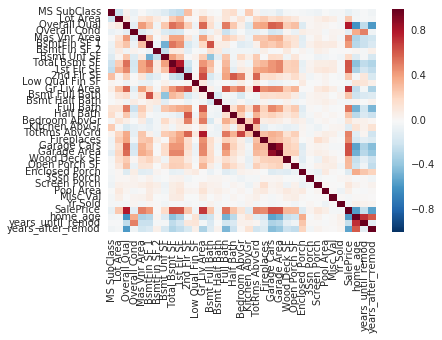

In [7]:
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
corrmat = numerical_df.corr()
sns.heatmap(corrmat)

In [8]:
corr_lst = corrmat['SalePrice'].abs().sort_values(ascending=False)
corr_lst

SalePrice            1.000000
Overall Qual         0.799262
Gr Liv Area          0.706780
Garage Cars          0.647812
Garage Area          0.640138
Total Bsmt SF        0.632529
1st Flr SF           0.621676
home_age             0.558907
Full Bath            0.545604
years_after_remod    0.534940
Mas Vnr Area         0.502196
TotRms AbvGrd        0.495474
Fireplaces           0.474558
BsmtFin SF 1         0.433147
Wood Deck SF         0.327143
Open Porch SF        0.312951
Half Bath            0.285056
Bsmt Full Bath       0.275823
2nd Flr SF           0.269373
Lot Area             0.266549
years_until_remod    0.240168
Bsmt Unf SF          0.183308
Bedroom AbvGr        0.143913
Enclosed Porch       0.128787
Kitchen AbvGr        0.119814
Screen Porch         0.112151
Overall Cond         0.101697
MS SubClass          0.085092
Pool Area            0.068403
Low Qual Fin SF      0.037660
Bsmt Half Bath       0.035817
3Ssn Porch           0.032225
Yr Sold              0.030569
Misc Val  

In [9]:
feature = corr_lst[corr_lst > 0.4]
numerical_df = numerical_df[feature.index]
numerical_df.head(5)

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,home_age,Full Bath,years_after_remod,Mas Vnr Area,TotRms AbvGrd,Fireplaces,BsmtFin SF 1
0,215000,6,1656,2.0,528.0,1080.0,1656,50,1,50,112.0,7,2,639.0
1,105000,5,896,1.0,730.0,882.0,896,49,1,49,0.0,5,0,468.0
2,172000,6,1329,1.0,312.0,1329.0,1329,52,1,52,108.0,6,0,923.0
3,244000,7,2110,2.0,522.0,2110.0,2110,42,2,42,0.0,8,2,1065.0
4,189900,5,1629,2.0,482.0,928.0,928,13,2,12,0.0,6,1,791.0


# Select nominal/category features

In [10]:
nominal_col = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

nominal_fea = []

for col in nominal_col:
    if col in transform_df.columns:
        nominal_fea.append(col)
        
nominal_fea

['MS SubClass',
 'MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air']

In [11]:
# Remove columns with low variance
for col in nominal_fea:
    max_val = transform_df[col].value_counts().max() 
    pct = max_val / len(transform_df)
    if pct > 0.90:
        nominal_fea.remove(col)

In [12]:
# Count number of unique values in a category
uniqueness_counts = transform_df[nominal_fea].apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Mas Vnr Type     5
Roof Style       6
Foundation       6
MS Zoning        7
House Style      8
Condition 1      9
MS SubClass     16
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [13]:
nominal_fea = [x for x in uniqueness_counts.index if uniqueness_counts[x] < 10]

numerical_list = numerical_df.columns.tolist()

numerical_list.extend(nominal_fea)

transform_df = transform_df[numerical_list]

transform_df.head(5)

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,home_age,Full Bath,years_after_remod,...,Central Air,Land Contour,Lot Config,Bldg Type,Mas Vnr Type,Roof Style,Foundation,MS Zoning,House Style,Condition 1
0,215000,6,1656,2.0,528.0,1080.0,1656,50,1,50,...,Y,Lvl,Corner,1Fam,Stone,Hip,CBlock,RL,1Story,Norm
1,105000,5,896,1.0,730.0,882.0,896,49,1,49,...,Y,Lvl,Inside,1Fam,None,Gable,CBlock,RH,1Story,Feedr
2,172000,6,1329,1.0,312.0,1329.0,1329,52,1,52,...,Y,Lvl,Corner,1Fam,BrkFace,Hip,CBlock,RL,1Story,Norm
3,244000,7,2110,2.0,522.0,2110.0,2110,42,2,42,...,Y,Lvl,Corner,1Fam,None,Hip,CBlock,RL,1Story,Norm
4,189900,5,1629,2.0,482.0,928.0,928,13,2,12,...,Y,Lvl,Inside,1Fam,None,Gable,PConc,RL,2Story,Norm


In [14]:
# Convert category values into dummy

text_col = transform_df.select_dtypes(include=['object'])

for col in text_col:
    transform_df[col] = transform_df[col].astype('category')
    
for col in text_col:
    col_dummies = pd.get_dummies(transform_df[col])
    transform_df = pd.concat([transform_df, col_dummies], axis=1)
    del transform_df[col]
   
transform_df.head(5)

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,Total Bsmt SF,1st Flr SF,home_age,Full Bath,years_after_remod,...,SLvl,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn
0,215000,6,1656,2.0,528.0,1080.0,1656,50,1,50,...,0,0,0,1,0,0,0,0,0,0
1,105000,5,896,1.0,730.0,882.0,896,49,1,49,...,0,0,1,0,0,0,0,0,0,0
2,172000,6,1329,1.0,312.0,1329.0,1329,52,1,52,...,0,0,0,1,0,0,0,0,0,0
3,244000,7,2110,2.0,522.0,2110.0,2110,42,2,42,...,0,0,0,1,0,0,0,0,0,0
4,189900,5,1629,2.0,482.0,928.0,928,13,2,12,...,0,0,0,1,0,0,0,0,0,0


# Update select_features function

In [15]:
def select_features(df):
    # Transform numerical columns
    numerical_df = df.select_dtypes(include=['int', 'float'])
    corr_lst = corrmat['SalePrice'].abs().sort_values(ascending=False)
    feature = corr_lst[corr_lst > 0.4]
    numerical_df = numerical_df[feature.index]
    
    # Transform nominal columns
    nominal_col = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

    nominal_fea = []

    for col in nominal_col:
        if col in df.columns:
            nominal_fea.append(col)
            
    for col in nominal_fea:
        max_val = df[col].value_counts().max() 
        pct = max_val / len(df)
        if pct > 0.90:
            nominal_fea.remove(col)
        
            
    text_col = df.select_dtypes(include=['object'])

    for col in text_col:
        df[col] = df[col].astype('category')
    
    for col in text_col:
        col_dummies = pd.get_dummies(df[col])
        df = pd.concat([df, col_dummies], axis=1)
        del df[col]
    
    return df

# Update train_and_test function

In [25]:
from sklearn.model_selection import cross_val_score

def train_and_test(df, k):
    
    rg = linear_model.LinearRegression()
    
    numeric_df = df.select_dtypes(['int', 'float'])
    features = numeric_df.columns.drop('SalePrice')
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]    
        rg.fit(train[features], train['SalePrice'])
        predict = rg.predict(test[features])
        rmse = mean_squared_error(test['SalePrice'], predict) ** (1/2)
        print(rmse)
    else:
        if k == 1:
            n = 2
        if k > 1:
            n = k
        
        kf = KFold(n, shuffle=True, random_state=1)
        mses = cross_val_score(rg, df[features], df["SalePrice"], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        rmse = np.mean(rmses)
        print(rmses)

    return rmse    

In [29]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=1)

rmse

[ 36749.03737822  31238.91229305]


33993.97483563477